# GloVe

Модель GloVe (Global Vectors), в отличие от Word2Vec, учитывает не только контекст, но и общую статистику встречаемости слова в корпусе при построении эмбеддингов. Для этого модель учитывает вероятность одновременно встретить два слова, опираясь на co-occurence матрицу (матрицу встречаемости слов). Другими словами, она учитывает, как часто слово $j$ встречается в контексте слова $i$ во всем корпусе текстов.

Пусть $X$ - матрица встречаемости слов, а $X_{ij}$ - количество раз, когда слово $j$ появилось в контексте слова $i$. Тогда вероятность встретить слово $j$ в контексте слова $i$ можно вычислить по формуле:

$P_{ij}$ = $P(j|i)$ = $\frac {X_{ij}} {\sum_{k \in context} X_{ik}}$  (1)

GloVe использует отношение вероятностей встретить два слова вместе, чтобы выучить информацию о контексте употребления слов. Рассмотрим подробнее на примере. Пусть у нас есть таблица вероятностей встретить вместе со словами "лед" и "пар" следующие слова: "твердый", "газ", "вода", "популярный".
 
|Вероятность           |k="твердый"        |k="газ"            |k="вода"           |k="популярный"      |
|----------------------|-------------------|-------------------|-------------------|--------------------|
|P(k\|лед)             |$1.9 \cdot 10^{-4}$|$6.6 \cdot 10^{-5}$|$3.0 \cdot 10^{-3}$|$1.7 \cdot 10^{-5}$ |
|P(k\|пар)             |$2.2 \cdot 10^{-5}$|$7.8 \cdot 10^{-4}$|$2.2 \cdot 10^{-3}$|$1.8 \cdot 10^{-5}$ |
|P(k\|лед)/P(k\|пар)   |$8.9$              |$8.5 \cdot 10^{-2}$|$1.36$             |$0.96$              |

Даже при беглом просмотре оказывается, что отношение вероятностей встречаемости двух слов несет больше информации, чем вероятность встретить одно слово в контексте другого. Например, мы не можем найти связь между словами "лед" и "пар" только по вероятности встретить их рядом, но глядя на отношение их вероятностей мы можем увидеть и запомнитьи скрытую связь "вода".

Теперь, когда мы поняли, что отношение вероятностей дает много информации об связи двух слов, научитмся предсказывать это отношение между двумя векторами слов $w_i$ и $w_j$ и вектором контекста $\tilde{w_k}$. Для этого построим функцию $F$:

$F(w_i, w_j, \tilde{w_k}) = \frac {P_{ik}} {P_{jk}}$  (2)

Итак, на вход функции $F$ подаются два вектора $w_i$ и $w_j$. Самый простой способ сравнить их - это найти их разность. Тогда формула (1) примет следующий вид:

$F(w_i - w_j, \tilde{w_k}) = \frac {P_{ik}} {P_{jk}}$  (3)

Теперь на вход функции подаются два вектора, а в результате мы получаем скалярное значение. Однако если оставить такое отношение, это будет добавлять математической сложности. Проще будет работать со скалярными значениями слева и справа, поэтому модель GloVe использует скалярное произведение входных векторов:

$F((w_i - w_j)^T\tilde{w_k}) = \frac {P_{ik}} {P_{jk}}$  (4)

Все это время мы разделяли векторы слов от вектора контекста. Однако матрица встречаемости слов $X$ симметрична, и для соблюдения этого свойства функция $F$ должна удовлетворять требованиям гомоморфизма, то есть:

${F(a + b) = \frac {F(a)} {F(b)}}$

Так как ${F((w_i - w_j)^T\tilde{w_k}) = {P_{ik}}}$, то

$F((w_i - w_j)^T\tilde{w_k}) = \frac {F(w_i^T\tilde{w_k})} {F(w_j^T\tilde{w_k})}$  (5)

Функция экспоненты удовлетворяет условию выше: ${\exp(a - b) = \frac {\exp(a)} {\exp(b)}}$, воспользуемся ей и получим:

$w_i^T\tilde{w_k} = log(P_{ik}) = log(X_{ik}) - log({\sum_{w \in context} X_{iw}})$  (6)

Для удоства обозначим $b_i = log({\sum_{w \in context} X_{iw}})$, а для восстановления симметрии добавим смещение $b_k$ вектору $w_k$. В результате получим выражение, которое позволяет получать статистическую информацию о корпусе текстов с сохранением симметрии:

$w_i^T\tilde{w_k} + b_i + \tilde{b_k} = log(X_{ik})$  (7)

Теперь, когда мы вывели выражение, которое позволяет извлекать информацию из матрицы встречаемости слов, построим целевую функцию, которую будем минимизировать в процессе обучения модели GloVe. Для получения эмбеддингов мы будем минимизировать квадрат расстояний между векторами слов $w_i$ и $w_j$. Также для сохранения информации потребуется функция весов $f(X_{ij})$, которая будет учитывать информацию о часто встречающихся сочетаниях слов и отбрасывать редкие или невозможные комбинации слов. Получаем целевую функцию вида 

$J = \sum_{i,j=1} ^{V} f(X_{ij})(w_i^T\tilde{w_k} + b_i + \tilde{b_k} - log(X_{ik}))^2$  (8)

$J \rightarrow min$

Попробуем на практике воспользоваться моделью GloVe с помощью реализации во фреймворке ```spacy```. Потребуется дополнительно установить предобученную модель для русского языка ```ru_core_news_lg```. Дополнительную информацию по установке можно найти по [ссылке](spacy.io/usage).

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import spacy  # для загрузки реализации GloVe

from tqdm import tqdm

from text_transformer import TextTransformer
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.manifold import TSNE  # алгоритм понижения размерности

In [3]:
sns.set_theme()
tqdm.pandas()
nlp = spacy.load('ru_core_news_lg')  # загрузка spacy-модели

In [4]:
DATA_PATH = "data/train.csv"
STOP_WORDS = 'data/stop_words.txt'
RANDOM_STATE = 42  # для фиксации генератора случайных чисел

Загрузим данные и сделаем предобработку текста с помощью spacy и препроцессора, написанного нами ранее. После этого разобьем данные на обучающую и валидационную выборку. 

In [5]:
df = pd.read_csv(DATA_PATH)
df.head()

,text,class
0,проблема: не открывается АКТ сверки по СБС № П...,1-46
1,В случае выбора неверного шаблона просьба указ...,1-70
2,Вопрос/информация Добрый день! В ЗНВ 300001962...,4-11
3,Вопрос/проблема: После выхода из отпуска с 01....,6-1
4,В УВХД необходимо снять резервирование с ЗНС *...,2-28


In [6]:
with open(STOP_WORDS, encoding='utf-8') as file:
    stop_words = [w.strip() for w in file.readlines()]

### Анализ и предобработка данных

In [7]:
text_tf = TextTransformer(stop_words)
df = text_tf.fit_transform(df)

df['spacy'] = df['cleaned'].progress_apply(nlp)
df['cleaned'] = df['spacy'].apply(lambda sentences: [token.text for token in sentences])
df.head()

  0%|          | 0/15449 [00:00<?, ?it/s]

100%|██████████| 15449/15449 [12:32<00:00, 20.53it/s]


,text,class,doc,num_tokens,num_sentences,cleaned,spacy
0,проблема: не открывается АКТ сверки по СБС № П...,1-46,Doc(text='проблема: не открывается АКТ сверки ...,15,1,"[открываться, акт, сверка, сбс, пакет, докумен...","(открываться, акт, сверка, сбс, пакет, докумен..."
1,В случае выбора неверного шаблона просьба указ...,1-70,Doc(text='В случае выбора неверного шаблона пр...,81,4,"[случай, выбор, неверный, шаблон, указать, наи...","(случай, выбор, неверный, шаблон, указать, наи..."
2,Вопрос/информация Добрый день! В ЗНВ 300001962...,4-11,Doc(text='Вопрос/информация Добрый день! В ЗНВ...,39,2,"[информация, знв, , графа, сумма, комиссия, н...","(информация, знв, , графа, сумма, комиссия, н..."
3,Вопрос/проблема: После выхода из отпуска с 01....,6-1,Doc(text='Вопрос/проблема: После выхода из отп...,90,6,"[выход, отпуск, .., меню, увхд, стать, короче,...","(выход, отпуск, .., меню, увхд, стать, короче,..."
4,В УВХД необходимо снять резервирование с ЗНС *...,2-28,Doc(text='В УВХД необходимо снять резервирован...,61,4,"[увхд, необходимый, снять, резервирование, знс...","(увхд, необходимый, снять, резервирование, знс..."


In [8]:
X_train, X_val, y_train, y_val = train_test_split(df['spacy'], df['class'], test_size=0.33, random_state=RANDOM_STATE)

Посмотреть количество слов, вошедших в словарь предобученной модели, можно следующим образом:

In [9]:
len(nlp.vocab.vectors)

500002

Построим визуализацию эмбеддингов для первых 30 слов. Для этого потребуется алгоритм понижения размерности TSNE, который позволит перейти от пространства размерности 300 к двумерному.

In [10]:
words = list(set(df['cleaned'].sum()))

In [11]:
glove_vectors = []
glove_words = []
i = 0

while len(glove_vectors) < 30:
    vector = nlp(words[i]).vector
    if vector.sum() != 0:
        glove_vectors.append(vector)
        glove_words.append(words[i])
    i += 1

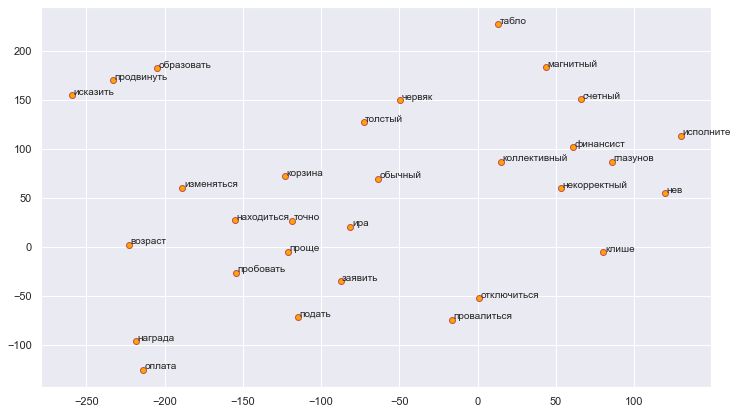

In [12]:
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(glove_vectors)

plt.figure(figsize=(12, 7));
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r');
for label, x, y in zip(glove_words, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x + 1, y + 1), xytext=(0, 0), textcoords='offset points');

Посмотрим, как выглядят эббеддинги для первых 30 слов:

In [13]:
vec_df = pd.DataFrame(glove_vectors, index=glove_words)
vec_df.style.background_gradient(axis=1)

Попробуем обучить классификатор на эмбеддингах GloVe. Получим векторное представление каждого текста из объекта spacy Document:

In [14]:
X_train_vectorised = X_train.apply(lambda text: text.vector)

In [15]:
X_train_vectorised.iloc[0].shape

(300,)

Так как все операции выполнялись с помощью pandas над numpy-массивами, требуется сделать еще одно преобразование, чтобы исправить проблему со сбившимися размерностями матрицы. После этого можно приступать к обучению.

In [16]:
X_train_arr = np.zeros((X_train_vectorised.shape[0], 300))
for i in range(X_train_vectorised.shape[0]):
    X_train_arr[i, :] = X_train_vectorised.iloc[i]

Повторим все преобразования для валидационной выборки:

In [17]:
X_val_vectorised = X_val.apply(lambda text: text.vector)

X_val_arr = np.zeros((X_val_vectorised.shape[0], 300))
for i in range(X_val_vectorised.shape[0]):
    X_val_arr[i, :] = X_val_vectorised.iloc[i]

### Обучение классификаторов

Обучим те же модели, что и в предыдущей части, и посмотрим на результат.

In [18]:
results = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score'])

In [19]:
svm = LinearSVC(random_state=RANDOM_STATE)
svm.fit(X_train_arr, y_train)

predicts = svm.predict(X_val_arr)

results.loc['W2V + SVM', 'accuracy'] = accuracy_score(y_val, predicts)
results.loc['W2V + SVM', 'precision'] = precision_score(y_val, predicts, average='weighted')
results.loc['W2V + SVM', 'recall'] = recall_score(y_val, predicts, average='weighted')
results.loc['W2V + SVM', 'f1-score'] = f1_score(y_val, predicts, average='weighted')

results

,accuracy,precision,recall,f1-score
W2V + SVM,0.595999,0.588403,0.595999,0.579401


In [20]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(X_train_arr, y_train.values.ravel())

predicts = rf.predict(X_val_arr)

results.loc['W2V + RF', 'accuracy'] = accuracy_score(y_val, predicts)
results.loc['W2V + RF', 'precision'] = precision_score(y_val, predicts, average='weighted')
results.loc['W2V + RF', 'recall'] = recall_score(y_val, predicts, average='weighted')
results.loc['W2V + RF', 'f1-score'] = f1_score(y_val, predicts, average='weighted')

results

,accuracy,precision,recall,f1-score
W2V + SVM,0.595999,0.588403,0.595999,0.579401
W2V + RF,0.432242,0.54372,0.432242,0.398289


In [21]:
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr.fit(X_train_arr, y_train.values.ravel())

predicts = lr.predict(X_val_arr)

results.loc['W2V + LogReg', 'accuracy'] = accuracy_score(y_val, predicts)
results.loc['W2V + LogReg', 'precision'] = precision_score(y_val, predicts, average='weighted')
results.loc['W2V + LogReg', 'recall'] = recall_score(y_val, predicts, average='weighted')
results.loc['W2V + LogReg', 'f1-score'] = f1_score(y_val, predicts, average='weighted')

results

,accuracy,precision,recall,f1-score
W2V + SVM,0.595999,0.588403,0.595999,0.579401
W2V + RF,0.432242,0.54372,0.432242,0.398289
W2V + LogReg,0.581879,0.59411,0.581879,0.567446


# Задание

1. Постройте GloVe-эмбеддинги для вашего датасета. Сделайте визуализацию для первых 50 слов.

2. Обучите модели классификации. Оцените с помощью метрик качество их работы. 